In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [104]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

setting = 'fuji'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

In [34]:
dfs = InsectImgDataset(ext=ext, setting=setting)
dfs.extract_df_info()

Extracting info from filenames..: 100%|█| 67841/67841 [00:07<00:00, 8629.27it/s]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 77.84it/s]


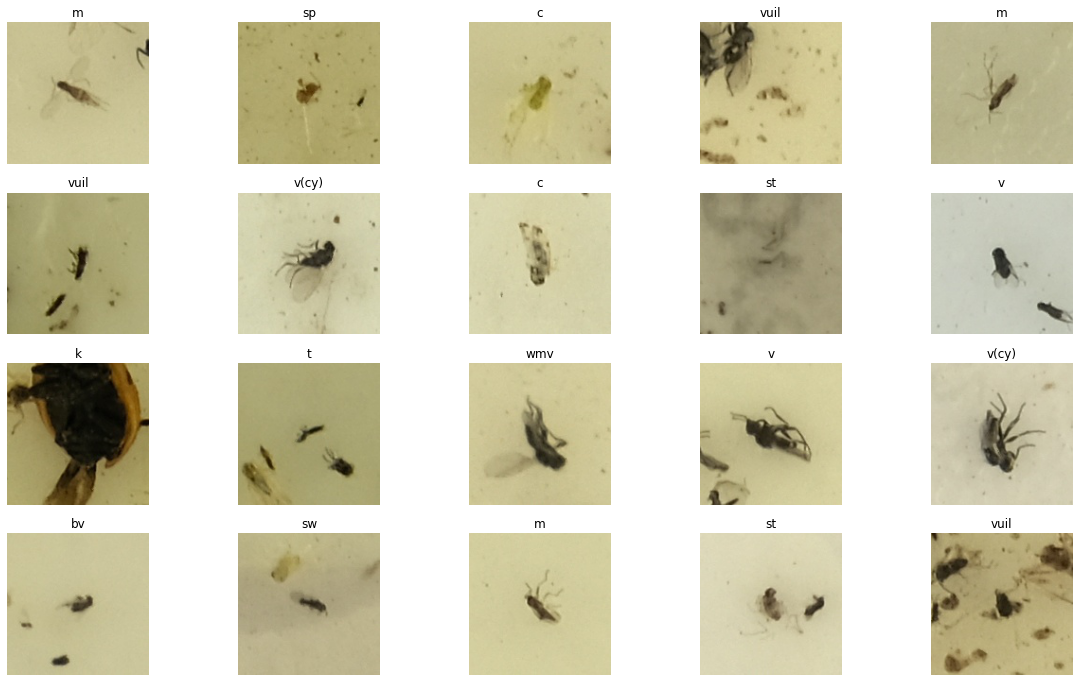

In [35]:
dfs.plot_samples()

# Extra feature collection

In [5]:
batch_size=32
dloader = DataLoader(dfs, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
l_blur_factors = []
l_meansRGB = []
l_stdsRGB = []
l_nb_contours, l_mean_cnt_area, l_mean_cnt_perimeter, l_std_cnt_area, l_std_cnt_perimeter = [],[],[],[],[]
for x,l,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(dloader, total=len(dfs)//batch_size, desc='Collecting all data from the dataloader..'):
    for f in filename:
        l_blur_factors.extend([calc_variance_of_laplacian(f)])
        meanRGB, stdRGB = calc_mean_RGB_vals(f)
        l_meansRGB.extend([meanRGB])
        l_stdsRGB.extend([stdRGB])
        nb_contours, cnt_areas, cnt_perimeters, mean_cnt_area, mean_cnt_perimeter, std_cnt_area, std_cnt_perimeter = calc_contour_features(f)
        l_nb_contours.extend([nb_contours])
        l_mean_cnt_area.extend([mean_cnt_area])
        l_mean_cnt_perimeter.extend([mean_cnt_perimeter])
        l_std_cnt_area.extend([std_cnt_area])
        l_std_cnt_perimeter.extend([std_cnt_perimeter])

In [197]:
df_rgb = pd.DataFrame(l_meansRGB, columns=['R','G','B'])
df_feats = pd.DataFrame({'blur': l_blur_factors, 
                        'nb_contours': l_nb_contours,
                        'mean_cnt_area': l_mean_cnt_area,
                        'mean_cnt_perimeter': l_mean_cnt_perimeter,
                        'std_cnt_area': l_std_cnt_area,
                        'std_cnt_perimeter': l_std_cnt_perimeter})
df_feats = pd.concat([df_feats, df_rgb], axis=1)
feature_columns = df_feats.columns

insect_classes = df.label.unique().tolist()

df = pd.concat([dfs.df, df_feats], axis=1)
df.sort_values(by='label', inplace=True)
df = df[df.label!='gv']
df.head()

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,nb_contours,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B
0,/media/kalfasyan/HGST_4TB/Datasets/pbox_vs_fuj...,bl,2020_Herent_w28_3-30_F10_51 mm_ISO160_1-15 s_I...,Herent_w28_3-30_F10_51 mm_ISO160_1-15 s_Incand...,2020,herent,w28,3-30,111,71.987292,14,105.678571,39.865342,326.035088,89.698608,176.267156,170.630400,116.370089
2419,/media/kalfasyan/HGST_4TB/Datasets/pbox_vs_fuj...,bl,2020_Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_I...,Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_Incand...,2020,herent,w29,2-90,104,88.129848,13,55.923077,23.992818,169.589872,49.227042,190.657467,185.285867,127.862933
2420,/media/kalfasyan/HGST_4TB/Datasets/pbox_vs_fuj...,bl,2020_Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_I...,Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_Incand...,2020,herent,w29,2-90,108,51.848843,5,107.800000,34.639192,211.371852,57.220296,194.040267,188.789822,132.719867
2421,/media/kalfasyan/HGST_4TB/Datasets/pbox_vs_fuj...,bl,2020_Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_I...,Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_Incand...,2020,herent,w29,2-90,112,45.801885,9,63.333333,19.742360,175.070145,36.852935,193.344133,187.679822,131.000178
2422,/media/kalfasyan/HGST_4TB/Datasets/pbox_vs_fuj...,bl,2020_Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_I...,Herent_w29_2-90_F10_51 mm_ISO160_1-15 s_Incand...,2020,herent,w29,2-90,132,69.320283,12,32.583333,17.875806,105.959472,43.221751,196.373600,191.353111,135.113689


# Outlier detection

### Performed per insect class

In [200]:
l_outlier_features = ['blur', 'nb_contours', 'R','G','B']

def class_outliers(df, features, insect='bl'):
    df = df[df.label==insect]
    outlier, outlier_score = detect_outliers(df[features].fillna(0).values, algorithm='KNN')    
    return outlier, outlier_score

df['knn_outlier'], df['knn_outlier_score'] = 0,0
outliers, scores = [],[]
for ins in tqdm(insect_classes, total=len(insect_classes)):
    out, scr = class_outliers(df, l_outlier_features, insect=ins)
    assert len(out) == df[df.label==ins].shape[0]
    outliers.extend(out)
    scores.extend(scr)
    
df['knn_outlier'], df['knn_outlier_score'] = outliers, scores

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 33.42it/s]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 78.62it/s]


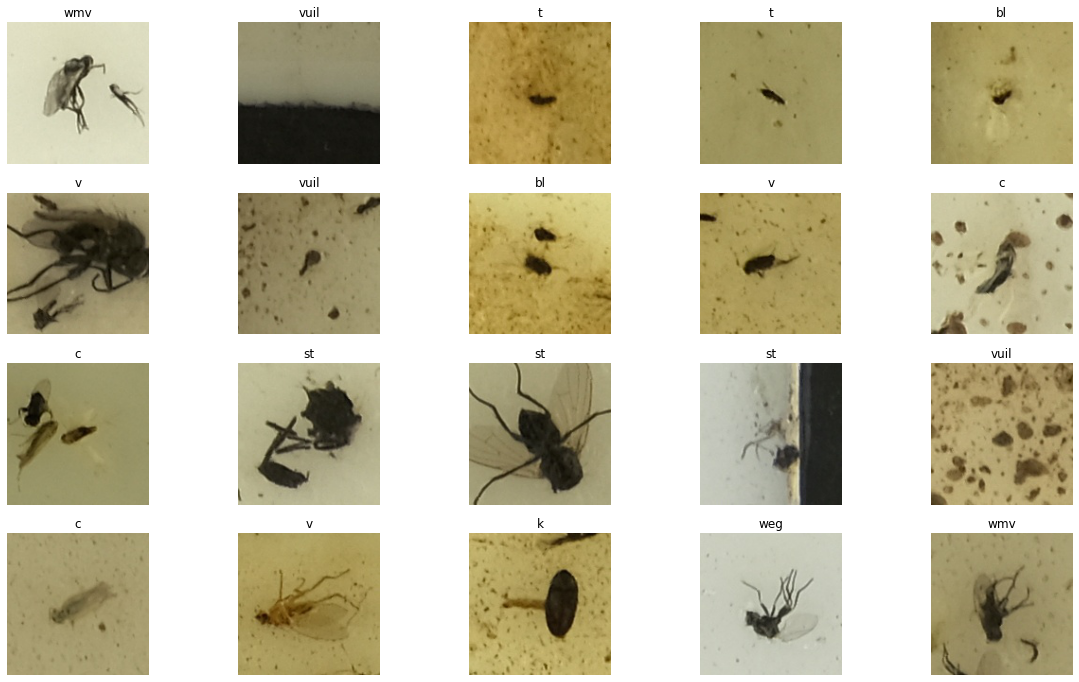

In [203]:
dfs.plot_samples(df[df.knn_outlier==1].sample(20))

In [204]:
df[df.knn_outlier==1].label.value_counts()

vuil     1163
v         865
c         822
t         647
m         599
st        593
wmv       532
bl        364
sw        306
v(cy)     221
k         193
bv        159
wrl       101
weg        91
sp         54
grv        39
w          20
wswl       20
Name: label, dtype: int64

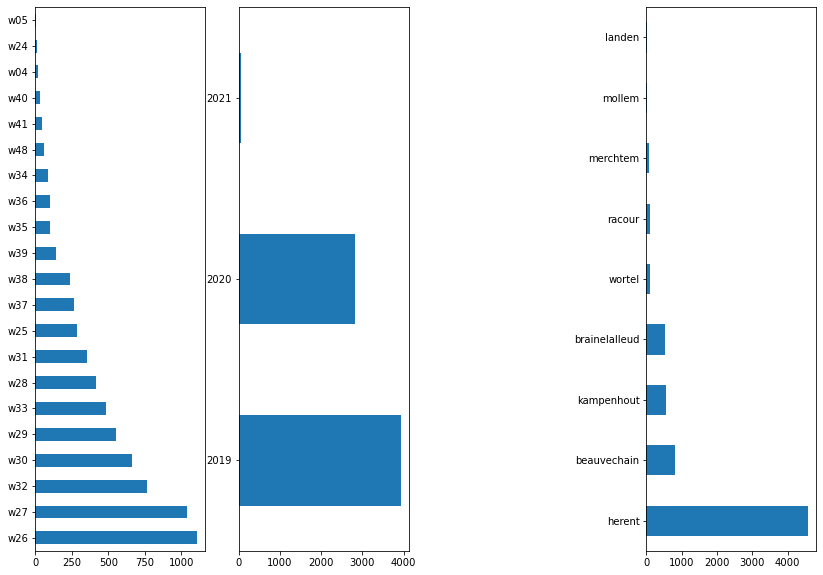

In [205]:
plt.figure(figsize=(24,12))
plt.subplot(1,4,1);
df[df.knn_outlier==1].date.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,2);
df[df.knn_outlier==1].year.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,4);
df[df.knn_outlier==1].location.value_counts().plot(kind='barh', figsize=(14,10));